In [25]:
from io import StringIO

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy import NaN
from functions import * # import functions from the .py file

from pylab import rcParams
rcParams["figure.figsize"] = 16, 4

PAYLOADSIZE = 14

if PAYLOADSIZE % 2 != 0:
    print("Alarm! the payload size is not even.")
NUM_16RND = (PAYLOADSIZE-2)//2 # how many 16 bits random number included in each frame
MAX_SEQ = 256 # (decimal) maximum seq number defined by the length of the seq, the length of seq is 1B

In [26]:
correct_payload = "E3 F1 C0" # 111000111111000111000000 --> 10110100
correct = parse_payload(correct_payload)
print(correct)
incorrect_payload = "C3  F1  C0" # 110000111111000111000000 --> 10110100
incorrect = parse_payload(incorrect_payload)
print(incorrect)

incorrect_payload = "83 F1 C0" # 100000111111000111000000 --> 00110100
incorrect = parse_payload(incorrect_payload)
print(incorrect)

[180, 180]
[180]
[52]


## Log file

**For a fair comparison between groups, must follow the output format below**
<br>$\color{red}{\text{timestamp_rx }|\text{ len [hex] } \text{ seq [hex] } \text{ payload [hex] }|\text{rssi}}$
<br>$\text{ len [hex]}$ = payload length + 1 (seq. field length [1B])
<br>$\text{ payload [hex]}$ should start with the pseudo sequence number [2B], indicates the starting byte's position in the file.
***
*Example log file output for one frame with reciever timestamp xxxx, frame length, seq number and random payload, received signal strength.*
<br>15:17:18.394 |0f 46 bd f8 f7 ea 41 ac 1b be 05 a0 7f d2 09 d4 |  -91 CRC error
<br>$\color{red}{\text{delimiter for four variables is "|" and delimiter for the payload each byte is the space " ".}}$

In [27]:
# define the file name
filename = "logs/1m_launch_firefly/1m_44_42_100k"
# import file to jupyter notebook
df = readfile("./" + filename)
# check the imported data first 10 lines
df.head(10)


,index,time_rx,rssi,seq,payload
0,0,2023-05-04 20:37:02.327,-89,0,00 00 13 5d 1f 43 1b 45 25 6f 21 fe 0f 7e
1,1,2023-05-04 20:37:02.389,-89,1,00 0c 20 6b 2b b0 24 4b 26 55 1a 56 22 ea
2,2,2023-05-04 20:37:02.437,-90,2,00 18 14 20 1f 30 25 19 1a 14 23 a8 23 8c
3,3,2023-05-04 20:37:02.553,-90,4,00 30 1c 08 23 fc 17 c2 22 1b 1c e4 25 de
4,4,2023-05-04 20:37:02.616,-89,5,00 3c 20 56 1c 27 1e 24 17 07 1a 80 27 e6
5,5,2023-05-04 20:37:02.679,-88,6,00 48 2a 99 2b 6b 1e 0d 1a 32 22 76 19 1f
6,6,2023-05-04 20:37:02.726,-88,7,00 54 25 a3 af 9e a5 88 22 97 1e 89 28 eb
7,7,2023-05-04 20:37:02.773,-89,8,00 60 16 6d 12 10 22 7b 2c 67 11 f6 1f a4
8,8,2023-05-04 20:37:02.836,-89,9,00 6c 12 ef 22 26 29 73 31 88 26 2d 1e 06
9,9,2023-05-04 20:37:02.899,-89,10,00 78 20 2d 2b f3 19 7d 20 ab 19 6b 0e 36


In [28]:
rssi = sum([x for x in df['rssi']])/len(df)
print("Avg rssi: ", rssi)

Avg rssi:  -91.074


In [29]:
# delete the corrupted packets (PAYLOADSIZE + 2B pesudo sequence number)
df = df[df.payload.apply(lambda x: len(x)==((PAYLOADSIZE)*3-1))]
df.reset_index(inplace=True)

In [30]:
# replace the resettable seq number to unresettable, for the purpose of reliability calculation
test = replace_seq(df.copy(), MAX_SEQ=256)
test.rename(columns = {'seq':'old_seq', 'new_seq':'seq'}, inplace = True)

# Time

## Definition

**Evaluation metric**
<br>*File Transmission Time: the total latency that certain amount of Data $F$ is delivered to the destination.*
<br> $File\ Delay = Rx\_timestamp[N] - Rx\_timestamp[0]$
<br> where $N$ is the last packet
***
**Interesting to look at**:
<br>*Timestamp difference*: $\Delta T[i] = Rx\_timestamp[i] - Tx\_timestamp[i]$
1. *Worst-case packet delay*: the delay of the packet that takes the longest time to traverse.
2. *Packet delay variation*: the std of the packet delay.

In [31]:
# compute the file delay
file_delay = df.time_rx[len(df) - 1] - df.time_rx[0]
# convert the timedelta to s
file_delay_s = np.timedelta64(file_delay, "ms").astype(int) / 1000
print(f"The time it takes to transfer the file is : {file_delay}, which is {file_delay_s} seconds.")

The time it takes to transfer the file is : 0 days 00:01:11.260000, which is 71.26 seconds.


# Reliability

## Definition

**Evaluation metric**
<br>*Quality of data transfer.*
<br>*Bit Reliability*: The ratio of data bits correctly delivered to the data sink.
<br>*Bit Error Rate*: The ratio of data bits incorrectly delivered to the data sink.
$$Bit\ Reliability = 1 - BER = 1 - \frac{Number\ of\ wrong\ bit}{Total\ Number\ of\ bit\ sent}$$
***
**Interesting to look at**:
1. *Expected number of transmission*: the ratio of the number of packets correctly received by the data sink and the number of packets sent by the source.

$$ETX = \frac{Number\ of\ packet\ received}{Number\ of\ packet\ sent}$$

2. *Packet reliability*: the number of packet bit correctly delivered to next hop.

## Statistics

In [32]:
# compute the BER for all received packets
# return the in total ber for received file, error statistics and correct file content supposed to be transmitted
ber, error, file_content, etx = compute_ber(test, PACKET_LEN=NUM_16RND*2, MAX_SEQ=MAX_SEQ)
bit_reliability = (1-ber)*100
print(f"Bit reliability [%]: {bit_reliability}")
print(f"ETX: {etx}")

The total number of packets transmitted by the tag is 3043.
Error statistics dataframe is:
       seq bit_error_tmp  bit_error
0        0           [8]          8
1        1           [9]          9
2        2          [10]         10
3        3            []         96
4        4          [11]         11
...    ...           ...        ...
3038  3038            []         96
3039  3039           [9]          9
3040  3040            []         96
3041  3041          [11]         11
3042  3042          [14]         14

[3043 rows x 3 columns]
Bit reliability [%]: 28.78601161134845
ETX: 3.043


In [33]:
# payload example for debug purpose
# correct sequence for pesudoseq NO. '0000'
tmp = file_content.loc[int('0000', base=16), 'data']
for i in tmp:
    print("{:02x}".format(i), end=" ")

13 5d 1f 43 1b 45 25 6f 21 fe 0f 7e 

Text(0.5, 0, 'Seq. Number')

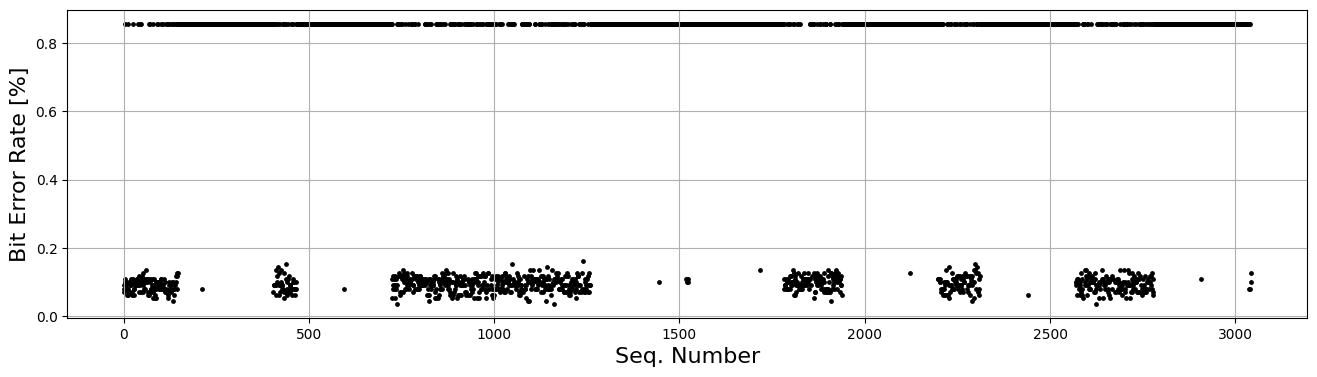

In [34]:
# BER for each packet
plt.scatter(error.seq, error.bit_error/(PAYLOADSIZE*8), marker='o', s=6, color='black')
plt.grid()
plt.ylabel('Bit Error Rate [%]', fontsize=16)
plt.xlabel('Seq. Number', fontsize=16)

# Distance

## Definition

**The communication distance of the system.**
<br>$D_{1}$: the distance between carrier<->backscatter_tag[m]
<br>$D_{2}$: the distance between backscatter_tag<->receiver[m]
<br> Distance metric = $D_{1}^2D_{2}^2$
<br>

In [35]:
# record the distance
dis_carrier_tag = 0.4
dis_tag_rx = 1

dis_metric = dis_carrier_tag**2*dis_tag_rx**2
print(f"Distance metric is: {dis_metric}")

Distance metric is: 0.16000000000000003


# Radarplot

**Please pay attention to the unit**
<br> <font color='red'>Time</font>: use second as unit
<br> <font color='red'>Reliability</font>: use the percent as unit
<br> <font color='red'>Distance</font>: use meter as unit
<br>**Metics = [Time(s), Reliability(%), Distance(m)]**
<br> <font color='red'>Always keep the reference in your plot.</font>
<br> Tips: for ploting, time metric uses $\frac{1}{Time}*1000$ as the time metric, the higher the value the better the system performance

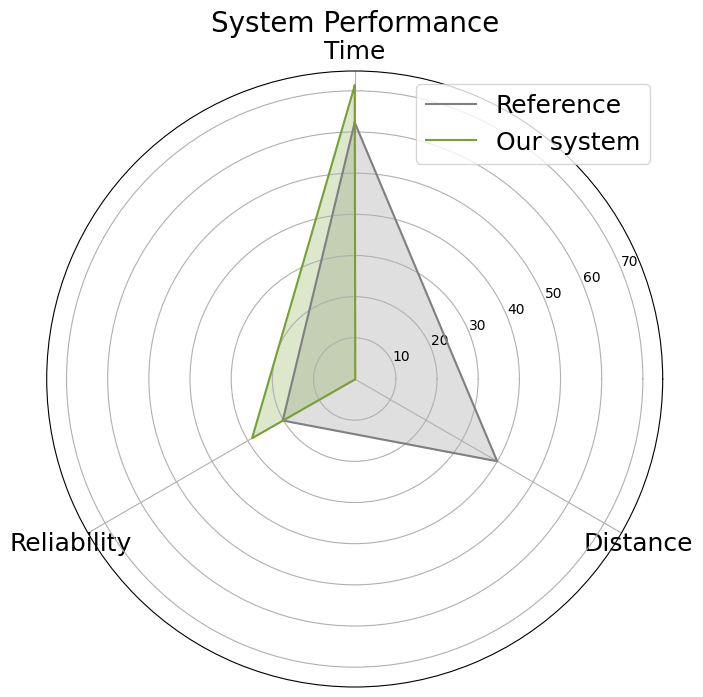

In [36]:
metrics = [file_delay_s, bit_reliability, dis_metric]
radar_plot(metrics)